In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score, roc_auc_score, RocCurveDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.over_sampling import SMOTE

In [4]:
df = pd.read_csv('train.csv').drop('id', axis=1)
df_test = pd.read_csv('test.csv').drop('id', axis=1)

Предработка: маппинг категорий

In [5]:
v_age_mapping = {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}
v_damage_mapping = {'Yes': True, 'No': False}
bool_mapping = {1: True, 0: False}

df['Vehicle_Age'] = df['Vehicle_Age'].map(v_age_mapping)
df_test['Vehicle_Age'] = df_test['Vehicle_Age'].map(v_age_mapping)

df['Vehicle_Damage'] = df['Vehicle_Damage'].map(v_damage_mapping)
df_test['Vehicle_Damage'] = df_test['Vehicle_Damage'].map(v_damage_mapping)

df['Driving_License'] = df['Driving_License'].map(bool_mapping)
df['Previously_Insured'] = df['Previously_Insured'].map(bool_mapping)
df_test['Driving_License'] = df_test['Driving_License'].map(bool_mapping)
df_test['Previously_Insured'] = df_test['Previously_Insured'].map(bool_mapping)

 Категориальные признаки

In [6]:
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('object')
df['Region_Code'] = df['Region_Code'].astype('object')
df_test['Policy_Sales_Channel'] = df_test['Policy_Sales_Channel'].astype('object')
df_test['Region_Code'] = df_test['Region_Code'].astype('object')

Масштабирование числовых признаков


In [7]:
numerical_features = df.select_dtypes(exclude=['object', 'bool']).drop('Response', axis=1).columns

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])
df_test[numerical_features] = scaler.transform(df_test[numerical_features])

One-hot кодирование

In [8]:
df = pd.get_dummies(df, drop_first=True)
df_test = pd.get_dummies(df_test, drop_first=True)

Выравнивание признаков train/test

In [9]:
train_cols = df.columns
test_cols = df_test.columns
missing_cols_train = set(test_cols) - set(train_cols)
missing_cols_test = set(train_cols) - set(test_cols)

df.drop(columns=missing_cols_test, inplace=True)
df_test.drop(columns=missing_cols_train, inplace=True)

Создание X, y

In [10]:
X_train = df.drop('Response', axis=1)
y_train = df['Response']
X_test = df_test.drop('Response', axis=1)
y_test = df_test['Response']

Удалим Vehicle_Age

In [11]:
X_train = X_train.drop('Vehicle_Age', axis=1)
X_test = X_test.drop('Vehicle_Age', axis=1)

Балансировка классов (SMOTE)

In [13]:
# уменьшим X_train до 100k перед SMOTE
X_small, _, y_small, _ = train_test_split(X_train, y_train, train_size=200_000, stratify=y_train, random_state=37)

# Применим SMOTE только к уменьшенному
X_res, y_res = SMOTE(random_state=37).fit_resample(X_small, y_small)

Функция для оценки моделей

In [15]:
model_scores = []

# Функция для оценки модели и сохранения метрик
def evaluate_model(model, name, X_test, y_test):
    print(f"\n--- {name} ---")
    y_pred = model.predict(X_test)

    # Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Interested', 'Interested'],
                yticklabels=['Not Interested', 'Interested'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Классификационный отчёт
    report = classification_report(y_test, y_pred, output_dict=True)

    # Все типы F1
    f1_binary = f1_score(y_test, y_pred, average='binary')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    roc = roc_auc_score(y_test, y_pred)

    print(classification_report(y_test, y_pred))
    print(f"F1 Binary: {f1_binary:.4f}")
    print(f"F1 Macro: {f1_macro:.4f}")
    print(f"F1 Weighted: {f1_weighted:.4f}")
    print(f"ROC AUC: {roc:.4f}")

    # Сохраняем метрики
    model_scores.append({
        'Model': name,
        'F1 Binary': f1_binary,
        'F1 Macro': f1_macro,
        'F1 Weighted': f1_weighted,
        'ROC AUC': roc,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall']
    })

Обучение моделей

In [59]:
# LightGBM
lgb_model = LGBMClassifier(random_state=37, n_estimators=200, num_leaves=11, reg_lambda=0.05, reg_alpha=0.1, boosting_type='goss')

In [17]:
def display_model_comparison():
    results_df = pd.DataFrame(model_scores)
    print("\n--- Model Comparison ---")
    display(results_df.sort_values(by='F1 Weighted', ascending=False))

Тестирование моделей

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 175389, number of negative: 175389
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,086351 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 350778, number of used features: 138
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0,500000 -> initscore=0,000000

--- LightGBM ---
[LightGBM] [Warning]

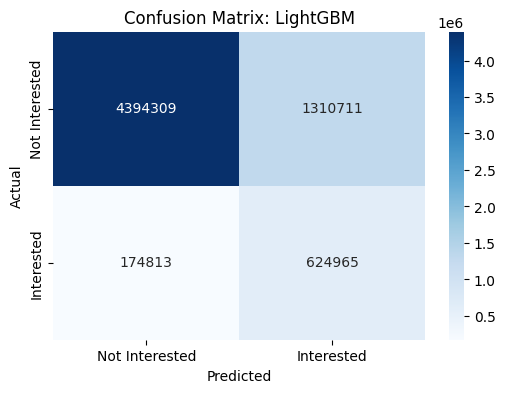

              precision    recall  f1-score   support

           0       0.96      0.77      0.86   5705020
           1       0.32      0.78      0.46    799778

    accuracy                           0.77   6504798
   macro avg       0.64      0.78      0.66   6504798
weighted avg       0.88      0.77      0.81   6504798

F1 Binary: 0.4569
F1 Macro: 0.6562
F1 Weighted: 0.8064
ROC AUC: 0.7758


In [60]:
# LightGBM
lgb_model.fit(X_res, y_res)
evaluate_model(lgb_model, "LightGBM", X_test, y_test)

In [62]:
import pickle

with open('lgb_BEST.pkl', 'wb') as f:
    pickle.dump({'model': lgb_model, 'scaler': scaler}, f)